In [2]:
import numpy as np
#import awkward
import awkward as ak

In [3]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [29]:
"""
def stack_arrays(a, keys, axis=-1):
    flat_arr = np.stack([a[k].flatten() for k in keys], axis=axis)
    return awkward.JaggedArray.fromcounts(a[keys[0]].counts, flat_arr)
"""


'\ndef stack_arrays(a, keys, axis=-1):\n    flat_arr = np.stack([a[k].flatten() for k in keys], axis=axis)\n    return awkward.JaggedArray.fromcounts(a[keys[0]].counts, flat_arr)\n'

In [4]:
"""
def pad_array(a, maxlen, value=0., dtype='float32'):
    x = (np.ones((len(a), maxlen)) * value).astype(dtype)
    for idx, s in enumerate(a):
        if not len(s):
            continue
        trunc = s[:maxlen].astype(dtype)
        x[idx, :len(trunc)] = trunc
    return x
"""
def pad_array(a, maxlen, value=0., dtype='float32'):
    """
    a: ak.Array jagged 1D
    Devuelve un np.ndarray (N, maxlen) con padding/clipping y casteo de tipo.
    """
    # 1) pad a longitud fija con None, clip si excede
    padded = ak.pad_none(a, maxlen, clip=True)      # docs: ak.pad_none
    # 2) reemplaza None por 'value'
    filled = ak.fill_none(padded, value)
    # 3) castea valores (equivalente moderno a .astype)
    casted = ak.values_astype(filled, np.dtype(dtype))
    # 4) a NumPy
    return ak.to_numpy(casted)



In [5]:
class Dataset(object):

    def __init__(self, filepath, feature_dict = {}, label='label', pad_len=100, data_format='channel_first'):
        self.filepath = filepath
        self.feature_dict = feature_dict
        if len(feature_dict)==0:
            feature_dict['points'] = ['part_etarel', 'part_phirel']
            feature_dict['features'] = ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel']
            feature_dict['mask'] = ['part_pt_log']
        self.label = label
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        self._values = {}
        self._label = None
        self._load()

    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
        
        counts = None
        #with awkward.load(self.filepath) as a:
        #    self._label = a[self.label]
        # Lee un único Parquet o un patrón (p. ej. 'converted/train_file_*.parquet').
        a = ak.from_parquet(
            self.filepath,
            columns=[self.label] + sum(self.feature_dict.values(), [])
        )
        #self._label = a[self.label]
        self._label = ak.to_numpy(a[self.label]).astype("float32")
        for k in self.feature_dict:
            cols = self.feature_dict[k]
            if not isinstance(cols, (list, tuple)):
                cols = [cols]
            arrs = []
            for col in cols:
                if counts is None:
                    #counts = a[col].counts
                    counts = ak.to_numpy(ak.num(a[col], axis=1))
                else:
                    #assert np.array_equal(counts, a[col].counts)
                    assert np.array_equal(counts, ak.to_numpy(ak.num(a[col], axis=1)))
                    
                arrs.append(pad_array(a[col], self.pad_len))
            self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)


    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        if key==self.label:
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]

In [32]:
#train_dataset = Dataset('converted/train_file_0.awkd', data_format='channel_last')
train_dataset = Dataset('converted/train_file_*.parquet', data_format='channel_last')

#val_dataset = Dataset('converted/val_file_0.awkd', data_format='channel_last')
val_dataset   = Dataset('converted/val_file_*.parquet',   data_format='channel_last')


[2025-08-09 21:38:12,131] INFO: Start loading file converted/train_file_*.parquet
[2025-08-09 21:38:30,602] INFO: Finished loading file converted/train_file_*.parquet
[2025-08-09 21:38:30,638] INFO: Start loading file converted/val_file_*.parquet
[2025-08-09 21:38:33,962] INFO: Finished loading file converted/val_file_*.parquet


In [33]:
import importlib, tf_keras_model
importlib.reload(tf_keras_model)


<module 'tf_keras_model' from '/home/diego.vasquez/Documents/ParticleNet-update/tf-keras/tf_keras_model.py'>

In [34]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite

In [35]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
num_classes = train_dataset.y.shape[1]
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}
if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [36]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 30

In [37]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2025-08-09 21:38:34,114] INFO: Learning rate: 0.001000


Model: "ParticleNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mask (InputLayer)   │ (None, 100, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 100, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_coord_… │ (None, 100, 1)    │          0 │ mask[0][0]        │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ points (InputLayer) │ (None, 100, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_fts_ex… │ (None, 100, 1, 4) │          0 │ features[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_add_pt… │ (None, 100, 2)    │          0 │ ParticleNet_coor… │
│ (Add)               │                   │            │ points[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_fts_bn  │ (None, 100, 1, 4) │         16 │ ParticleNet_fts_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_EdgeCo… │ (None, 100, 100)  │          0 │ ParticleNet_add_… │
│ (Lambda)            │                   │            │ ParticleNet_add_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_fts_sq… │ (None, 100, 4)    │          0 │ ParticleNet_fts_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_EdgeCo… │ (None, 100, 7)    │          0 │ ParticleNet_Edge… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_EdgeCo… │ (None, 100, 7, 4) │          0 │ ParticleNet_fts_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_EdgeCo… │ (None, 100, 7, 4) │          0 │ ParticleNet_fts_… │
│ (Lambda)            │                   │            │ ParticleNet_Edge… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_EdgeCo… │ (None, 100, 7, 8) │          0 │ ParticleNet_Edge… │
│ (Lambda)            │                   │            │ ParticleNet_Edge… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_EdgeCo… │ (None, 100, 7,    │        256 │ ParticleNet_Edge… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_EdgeCo… │ (None, 100, 7,    │        128 │ ParticleNet_Edge… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_EdgeCo… │ (None, 100, 7,    │          0 │ ParticleNet_Edge… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ParticleNet_EdgeCo… │ (None, 100, 7,    │      1,024 │ ParticleNet_Edge… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 26,898 (105.07 KB)

 Trainable params: 26,122 (102.04 KB)

 Non-trainable params: 776 (3.03 KB)

In [39]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [40]:
train_dataset.shuffle()
model.fit(train_dataset.X, train_dataset.y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=1, # --- train only for 1 epoch here for demonstration ---
          validation_data=(val_dataset.X, val_dataset.y),
          shuffle=True,
          callbacks=callbacks)

[2025-08-09 21:38:42,075] INFO: Learning rate: 0.001000


2268/2268 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9039 - loss: 0.2403
Epoch 1: val_accuracy improved from None to 0.92685, saving model to model_checkpoints/particle_net_lite_model.001.h5


[2025-08-09 23:03:21,506] WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


2268/2268 ━━━━━━━━━━━━━━━━━━━━ 5080s 2s/step - accuracy: 0.9196 - loss: 0.1998 - val_accuracy: 0.9268 - val_loss: 0.1806 - learning_rate: 0.0010


# Test
Cargar el mejor modelo guardado

In [6]:
# Cargar el conjunto de test
test_dataset = Dataset('converted/test_file_*.parquet', data_format='channel_last')
print(len(test_dataset.y), {k: v.shape for k, v in test_dataset.X.items()})


[2025-08-09 23:25:42,478] INFO: Start loading file converted/test_file_*.parquet
[2025-08-09 23:25:42,660] INFO: Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
[2025-08-09 23:25:42,661] INFO: NumExpr defaulting to 16 threads.
[2025-08-09 23:25:46,153] INFO: Finished loading file converted/test_file_*.parquet


404000 {'points': (404000, 100, 2), 'features': (404000, 100, 4), 'mask': (404000, 100, 1)}


In [7]:
import os, glob
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite

# Descubrir shapes desde el test (idénticos a train/val)
num_classes = test_dataset.y.shape[1]
input_shapes = {k: test_dataset[k].shape[1:] for k in test_dataset.X}

# Reconstruir arquitectura original (sin cambios)
model_type = 'particle_net_lite'
model = get_particle_net_lite(num_classes, input_shapes) if 'lite' in model_type else \
        get_particle_net(num_classes, input_shapes)

# Cargar último checkpoint .h5
save_dir = 'model_checkpoints'
ckpts = sorted(glob.glob(os.path.join(save_dir, '*.h5')), key=os.path.getmtime)
assert ckpts, "No se encontró ningún checkpoint .h5 en model_checkpoints/"
best_ckpt = ckpts[-1]
print("Cargando pesos de:", best_ckpt)
model.load_weights(best_ckpt)

# Compilar solo para métricas estándar en evaluate()
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])



2025-08-09 23:26:47.727573: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/diego.vasquez/.conda/envs/particlenet/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/diego.vasquez/.conda/envs/particlenet/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibi

Cargando pesos de: model_checkpoints/particle_net_lite_model.001.h5


W0000 00:00:1754796410.174080  875435 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
#  Inferencia en test (batches grandes para CPU)

import numpy as np

batch_size_pred = 4096  # ajusta según RAM/CPU
pred = model.predict(test_dataset.X, batch_size=batch_size_pred, verbose=1)
# pred.shape -> (N, 2) con softmax
y_true = np.argmax(test_dataset.y, axis=1).astype(int)
y_score_signal = pred[:, 1]  # prob. clase 1 (señal)


99/99 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step


In [12]:
# Métricas clásicas (accuracy, ROC AUC, matriz de confusión, PR)

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_fscore_support, confusion_matrix, average_precision_score, classification_report

y_pred = np.argmax(pred, axis=1)
acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_score_signal)
ap  = average_precision_score(y_true, y_score_signal)

print(f"Test Accuracy: {acc:.4f}")
print(f"ROC AUC:       {auc:.4f}")
print(f"Avg Precision: {ap:.4f}")

print("\nMatriz de confusión:")
print(confusion_matrix(y_true, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, digits=4))


Test Accuracy: 0.9280
ROC AUC:       0.9797
Avg Precision: 0.9826

Matriz de confusión:
[[191513  10573]
 [ 18499 183415]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9119    0.9477    0.9295    202086
           1     0.9455    0.9084    0.9266    201914

    accuracy                         0.9280    404000
   macro avg     0.9287    0.9280    0.9280    404000
weighted avg     0.9287    0.9280    0.9280    404000



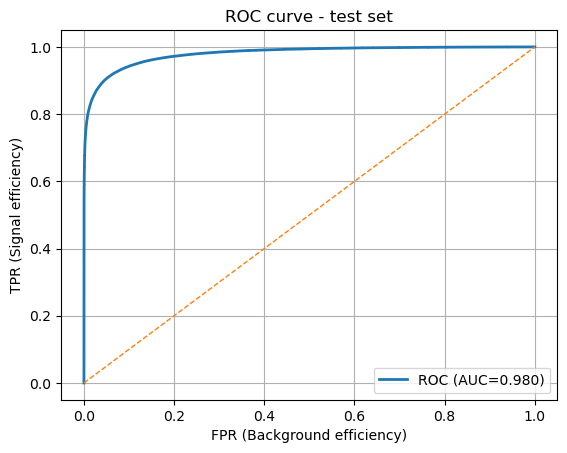

Umbral @ ~50% TPR: 0.9975
Background eff: 0.0001  ->  Background rejection: 6736.20x


In [13]:
# Curva ROC y punto operativo (rechazo de fondo al 50% de eficiencia de señal)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_true, y_score_signal)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel('FPR (Background efficiency)')
plt.ylabel('TPR (Signal efficiency)')
plt.title('ROC curve - test set')
plt.legend()
plt.grid(True)
plt.show()

# Ejemplo: buscar umbral para ~50% de eficiencia de señal
target_eff = 0.5
idx = np.argmin(np.abs(tpr - target_eff))
thr_50 = thr[idx]
bkg_eff_50 = fpr[idx]
bkg_rej_50 = 1.0 / max(bkg_eff_50, 1e-12)

print(f"Umbral @ ~{target_eff*100:.0f}% TPR: {thr_50:.4f}")
print(f"Background eff: {bkg_eff_50:.4f}  ->  Background rejection: {bkg_rej_50:.2f}x")


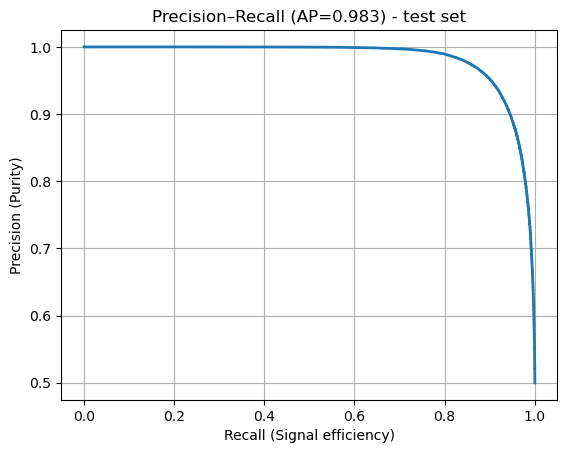

In [14]:
# Curva Precision–Recall (útil si hay desbalance)
from sklearn.metrics import precision_recall_curve

precision, recall, pr_thr = precision_recall_curve(y_true, y_score_signal)

plt.figure()
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall (Signal efficiency)')
plt.ylabel('Precision (Purity)')
plt.title(f'Precision–Recall (AP={ap:.3f}) - test set')
plt.grid(True)
plt.show()


In [15]:
# guardar predicciones

import pandas as pd

out = pd.DataFrame({
    'y_true': y_true,
    'p_signal': y_score_signal,
    'y_pred': y_pred,
})
out_path = 'test_predictions.parquet'
out.to_parquet(out_path, index=False)
print("Predicciones guardadas en:", out_path)


Predicciones guardadas en: test_predictions.parquet


---
---

In [16]:
# Métricas de evaluación (loss/acc), predicciones y reportes
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 3.1) Evaluación directa en Keras
test_loss, test_acc = model.evaluate(test_dataset.X, test_dataset.y, batch_size=2048, verbose=1)
print(f"[Test] loss={test_loss:.4f}  acc={test_acc:.4f}")

# 3.2) Predicciones (probabilidades por clase)
y_score = model.predict(test_dataset.X, batch_size=2048, verbose=1)  # (N, C)
y_true = test_dataset.y                                      # one‑hot (N, C)
y_pred = y_score.argmax(axis=1)
y_true_labels = y_true.argmax(axis=1)

# 3.3) Matriz de confusión y métricas por clase
cm = confusion_matrix(y_true_labels, y_pred)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_true_labels, y_pred, digits=4))

# 3.4) ROC‑AUC (multiclase) usando proba/scores
try:
    auc_ovr = roc_auc_score(y_true, y_score, multi_class='ovr')
    print(f"ROC-AUC (OvR): {auc_ovr:.4f}")
except ValueError as e:
    print("ROC-AUC no disponible (quizá clases únicas en test):", e)


198/198 ━━━━━━━━━━━━━━━━━━━━ 149s 750ms/step - accuracy: 0.9280 - loss: 0.1781
[Test] loss=0.1781  acc=0.9280
198/198 ━━━━━━━━━━━━━━━━━━━━ 151s 761ms/step
Confusion matrix:
 [[191513  10573]
 [ 18499 183415]]

Classification report:
               precision    recall  f1-score   support

           0     0.9119    0.9477    0.9295    202086
           1     0.9455    0.9084    0.9266    201914

    accuracy                         0.9280    404000
   macro avg     0.9287    0.9280    0.9280    404000
weighted avg     0.9287    0.9280    0.9280    404000

ROC-AUC (OvR): 0.9797


In [17]:
# Guardar todo en test.h5 (scores, etiquetas, métricas)
import h5py, time

out_path = "test.h5"
with h5py.File(out_path, "w") as f:
    f.create_dataset("y_true", data=y_true, compression="gzip", compression_opts=4)
    f.create_dataset("y_score", data=y_score, compression="gzip", compression_opts=4)
    f.create_dataset("y_pred", data=y_pred, compression="gzip", compression_opts=4)
    f.create_dataset("y_true_labels", data=y_true_labels, compression="gzip", compression_opts=4)
    f.create_dataset("confusion_matrix", data=cm, compression="gzip", compression_opts=4)
    # Atributos con métricas globales
    f.attrs["test_loss"] = float(test_loss)
    f.attrs["test_accuracy"] = float(test_acc)
    if 'auc_ovr' in locals():
        f.attrs["roc_auc_ovr"] = float(auc_ovr)
    f.attrs["timestamp"] = time.strftime("%Y-%m-%d %H:%M:%S")

print("Resultados de test guardados en:", out_path)


Resultados de test guardados en: test.h5
